In [1]:
### IMPORTS ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from dictionaries import *
from ANN import *


In [2]:
### GLOBAL PARAMETERS ###

t = time.time()         # to display runtime later
sample_size = 2
filename = 'ML_input_' + str(sample_size) + 'gm.csv'


In [3]:
### DATA IMPORT ###

# split parameters
test_size = 0.2
random_state = 42

# read in
attr_data = pd.read_csv(filename, usecols = attr_keys).values
labl_data = pd.read_csv(filename, usecols = labl_keys).values

# test/train split
attr_train, attr_test, labl_train, labl_test = train_test_split(attr_data, labl_data, test_size=test_size, random_state=random_state)


In [4]:
## MODEL PARAMETERS ###

# CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Layers
n_in = len(attr_keys)
n_out = len(labl_keys)
n_hidden = 60

# Training
learning_rate = 0.001
epochs = 2500

# Optimiser
optimiser = torch.optim.Adamax

# Activation
activation_fn = nn.Sigmoid()

# Loss
loss_fn = nn.L1Loss()

# plot interval
rec_interval = 5


In [5]:
### LOGISTICAL REGRESSION MODEL ###

# Run a logistic regression before doing the tensor conversion
logit = LogisticRegression(solver='liblinear')
lr_accs = [0.]*n_out

for i in [1,3]:
    logit.fit(attr_train, labl_train.T[i])
    lr_accs[i] = logit.predict_proba(attr_test)[:,1].tolist()
for i in [0,2]:
    lr_accs[i] = [0.]*len(lr_accs[1]) # continuous outputs cannot be modelled, placeholder values used


In [6]:
### TENSOR CONVERSIONS ###

lr_accs = torch.FloatTensor(lr_accs).T
attr_train = torch.FloatTensor(attr_train).to(device)
attr_test = torch.FloatTensor(attr_test).to(device)
labl_train = torch.FloatTensor(labl_train).to(device)
labl_test = torch.FloatTensor(labl_test).to(device)

In [7]:
### MODEL FUNCTIONS ###

# Function for reading accuracy of result which rounds to 0 or 1
def binary_acc(Y_hat, Y, index):
        
    successes = 0
    confidence = [0]*len(Y_hat)
    calc = Y_hat.T.tolist()[index]
    real = Y.T.tolist()[index]

    for i in range(len(calc)):

        confidence[i] = 1 - abs(round(calc[i]) - calc[i])
        successes += int(round(calc[i]) == real[i])
        
    accuracy = successes / len(calc)
    avg_conf = np.mean(confidence)

    return accuracy, avg_conf

def cont_acc(Y_hat, Y, index):

    calc = Y_hat.T.tolist()[index]
    real = Y.T.tolist()[index]
    
    SE = []
    for i in range(len(Y_hat.T[index])):
        SE.append((real[i] - calc[i])**2)

    return np.mean(SE)

def train(optimiser, loss_fn, attr_train, attr_test, labl_train, labl_test, rec_interval, n_in, n_hidden, n_out):

    # initialise model and results storage
    model = ANN(activation_fn, n_in, n_hidden, n_out).to(device)
    optimiser = optimiser(model.parameters(), lr=learning_rate)
    losses = []
    accs = [ [] for i in range(n_out)]

    # run the model
    for i in range(epochs):

        # calculate
        labl_hat = model.forward(attr_train)
        loss = loss_fn(labl_hat, labl_train)

        # update model
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # for plotting
        if not i % rec_interval: 
            with torch.no_grad():
                Y_hat = model.forward(attr_test)
            accs[0].append(cont_acc(Y_hat, labl_test, 0))
            accs[1].append(binary_acc(Y_hat, labl_test, 1)[0])
            accs[2].append(cont_acc(Y_hat, labl_test, 2))
            accs[3].append(binary_acc(Y_hat, labl_test, 3)[0])
            losses.append(loss.item())
            
    return model, accs, losses


Final Loss: 0.20171265304088593
Runtime: 51.35194182395935s


Text(0.5, 0, 'x5 Epochs')

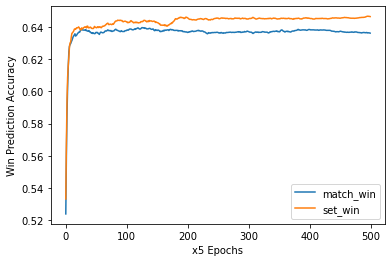

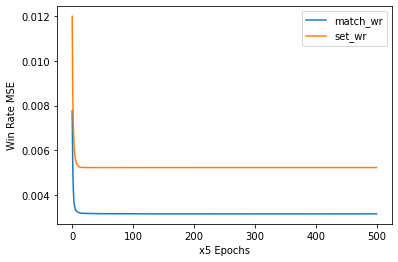

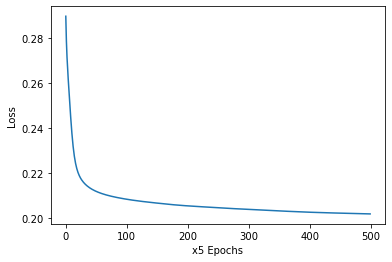

In [8]:
### RUN AND DISPLAY THE MODEL TRAINING LOSS AND ACCURACY ###

model, accs, losses = train(optimiser, loss_fn, attr_train, attr_test, labl_train, labl_test, rec_interval, n_in, n_hidden, n_out)
torch.save(model, 'model_'+str(sample_size)+'gm.torch')

# Display
print(f'Final Loss: {losses[-1]}')
print(f'Runtime: {time.time() - t}s')

# Accuracy
plt.plot(accs[1])
plt.plot(accs[3])
plt.ylabel('Win Prediction Accuracy')
plt.xlabel(f'x{rec_interval} Epochs')
plt.legend(['match_win', 'set_win'])

# Accuracy
plt.figure()
plt.plot(accs[0])
plt.plot(accs[2])
plt.ylabel('Win Rate MSE')
plt.xlabel(f'x{rec_interval} Epochs')
plt.legend(['match_wr', 'set_wr'])

# Loss
plt.figure()
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel(f'x{rec_interval} Epochs')


In [9]:
### MEASURE ACCURACY ###

# of the logistic regressions
lr_match_win_acc, lr_match_avg_conf = binary_acc(lr_accs, labl_test, 1)
lr_set_win_acc, lr_set_avg_conf = binary_acc(lr_accs, labl_test, 3)

# Run the model forward with test data
with torch.no_grad():
    Y_hat = model.forward(attr_test)

print(f'nn_match_win correct {round(accs[1][-1]*100,2)}% of the time for sample size of {sample_size} games')
print(f'lr_match_win correct {round(lr_match_win_acc*100,2)}% of the time with average system confidence {lr_match_avg_conf} for sample size of {sample_size} games')
print(f'nn_set_win correct {round(accs[3][-1]*100,2)}% of the time for sample size of {sample_size} games')
print(f'lr_set_win correct {round(lr_set_win_acc*100,2)}% of the time  with average system confidence {lr_set_avg_conf} for sample size of {sample_size} games')
print(f'nn_match_wr MAE: {accs[0][-1]}')
print(f'nn_set_wr MAE: {accs[2][-1]}')
      

nn_match_win correct 63.63% of the time for sample size of 2 games
lr_match_win correct 64.19% of the time with average system confidence 0.6334448149843532 for sample size of 2 games
nn_set_win correct 64.66% of the time for sample size of 2 games
lr_set_win correct 64.93% of the time  with average system confidence 0.6421339422645517 for sample size of 2 games
nn_match_wr MAE: 0.003140822449529804
nn_set_wr MAE: 0.005216470488866442


In [10]:
### GET THE AVERAGE OF EVERY FEATURE'S WEIGHTS BETWEEN INPUT AND HIDDEN LAYERS ###

avg_weights = {k:0 for k in attr_keys}
for i in range(n_in):
    avg_weights[attr_keys[i]] = np.mean(model.linear_in.weight.T[i].tolist())
    
print(avg_weights)


{'svr': 0.012712281446632308, 'pt_wr': -0.01871325491229072, 'gm_wr': -0.03913850439712405, 'f0': 0.0015624587230073908, 'r0': 0.008147637887547413, 'v0': -0.019321593931332853, 'u0': 0.01375322313203166, 'l0': 0.013413935084827244, 'h0': -0.004336394639297699, 'j0': -0.0028228469581032794, 'o0': 0.00479373440806133, 'b0': 0.012227038783263804, 's0': -0.009088189026806503, 'z0': 0.0014109504582847875, 'y0': 0.0051366966838637985, 'm0': -0.011645487675559707, 'i0': -0.00785327615449205, 'k0': -0.01634867350027586, 'p0': 0.008523597036643574, 't0': 0.01353401931701228, 'q0': -0.012616514189479252, '@0': -0.031604090080751726, '10': 0.003970800256744648, '20': -0.0035222084106256565, '30': -0.0007176091661676764, '40': 0.005301302384274701, '50': -0.00595619360950271, '60': 0.017723013546007374, '70': -0.024873512672881286, '80': 0.015157776426834364, '90': 0.013214780273847282, '+0': -0.0077626142985536715, 'hnd0': 0.008487346969195642, 'fr0': 0.009130242516403087, 'fsr0': -0.00318170179

In [12]:
### MEASURE IMPACT OF EACH INPUT PARAMETER ###
on = True

impacts = {k:0 for k in attr_keys}
standard = accs[1][-1]

for k in attr_keys:
    
    if not on:
        break
    
    tmp = attr_keys.copy()
    tmp.remove(k)

    # read in
    attr_data = pd.read_csv(filename, usecols = tmp).values
    labl_data = pd.read_csv(filename, usecols = labl_keys).values

    # test/train split
    attr_train, attr_test, labl_train, labl_test = train_test_split(attr_data, labl_data, test_size=test_size, random_state=random_state)

    attr_train = torch.FloatTensor(attr_train).to(device)
    attr_test = torch.FloatTensor(attr_test).to(device)
    labl_train = torch.FloatTensor(labl_train).to(device)
    labl_test = torch.FloatTensor(labl_test).to(device)
    
    model, accs, losses = train(optimiser, loss_fn, attr_train, attr_test, labl_train, labl_test, rec_interval, len(tmp), n_hidden, n_out)
    
    impacts[k] = (accs[0][-1] - standard) / standard

if on:
    print(impacts)


{'svr': -0.9950620561678664, 'pt_wr': -0.9950631168170088, 'gm_wr': -0.9950255624361322, 'f0': -0.9950667709480481, 'r0': -0.9950687870614349, 'v0': -0.9950637323010457, 'u0': -0.9950630787749745, 'l0': -0.9950624354978904, 'h0': -0.9950640605442155, 'j0': -0.9950638425353469, 'o0': -0.9950640308160599, 'b0': -0.9950649847505829, 's0': -0.9950642518988051, 'z0': -0.9950635547615623, 'y0': -0.9950684727174731, 'm0': -0.9950663649597525, 'i0': -0.995065155586625, 'k0': -0.9950670453173477, 'p0': -0.9950662718372764, 't0': -0.9950660320879428, 'q0': -0.9950628872299994, '@0': -0.9950671212812097, '10': -0.9950662390031616, '20': -0.9950683737623107, '30': -0.9950658174797167, '40': -0.9950657794258612, '50': -0.9950644544725677, '60': -0.9950650506217635, '70': -0.9950639060754046, '80': -0.9950653839247999, '90': -0.9950691459093595, '+0': -0.9950651154235758, 'hnd0': -0.995064993840135, 'fr0': -0.9950678856686043, 'fsr0': -0.9950682128845385, 'swr0': -0.995066060517525, 'ssr0': -0.99506